In [1]:
%%capture
import numpy as np
from functools import reduce
import time
%run commute.ipynb
%run diagonalize.ipynb
%run phase.ipynb
%run QDrift.ipynb
%run hamiltonian.ipynb

In [2]:
def Simulation_cost(Chs, CPs):
    """ Returns the cost of the simulation,
    total costs, individual costs in [crzs, toffolis]
    """
    crzs, Toffolis = 0, 0
    icosts = []
    n = len(CPs[0][0])
    for Ch, CP in zip(Chs, CPs):
        _, CZ, _ = diag_results(CP, True)
        print(CZ, CP)
        _, _, cost = logic_min(CZ, Ch)
        crzs += cost[0]
        Toffolis += cost[1]
        icosts.append([cost[0], cost[1]])
    tcost = [crzs, Toffolis]
    return np.array(tcost), np.array(icosts)

def Hs_sum(CHs, Chs):
    """ Regroups the cliques according to coefficients
    """
    tolerance = 1e-3
    SHs, Shs = [], []
    for CH, Ch in zip(CHs, Chs):
        SH, Sh = [], []
        idx = np.argsort(Ch)
        sCH, sCh = np.array(CH)[idx][::-1], np.array(Ch)[idx][::-1]
        while len(sCh) > 0:
            if np.abs(sCh[0]) < tolerance:
                break
            Sh.append(sCh[0])
            SH.append(np.sum(sCH, axis=0))
            sCh = sCh - sCh[0]
            cut = (-1*tolerance > sCh) | (sCh > tolerance)
            sCh = sCh[cut]
            sCH = sCH[cut]
        SHs.append(SH); Shs.append(Sh) 
    return SHs, Shs

def Hs_sum_costs(SHs, Shs, icosts):
    Hs_s, hs_s, costs = [], [], []
    for SH, Sh, icost in zip(SHs, Shs, icosts):
        for H, h in zip(SH, Sh):
            Hs_s.append(H); hs_s.append(h), costs.append(icost)
    return np.array(Hs_s), np.array(hs_s), costs



In [16]:
n, Hm, Hs, hs, Ps = LiH_hamiltonian()

terms = list(zip(Hs, hs, Ps))
terms1 = [list(term) for term in terms]
terms = np.array(terms1, dtype=object)
terms = terms[np.abs(terms[:, 1]).argsort()]



# Reorder 
terms[[16,22]] = terms[[22,16]]
terms[[17,23]] = terms[[23,17]]
terms[[18,20]] = terms[[20,18]]
terms[[19,21]] = terms[[21,19]]

# XY
terms[5][:2], terms[6][:2] = -terms[5][:2], -terms[6][:2]
terms[5][2], terms[6][2] = '-'+terms[5][2], '-'+terms[6][2]


# Z
terms[22][:2], terms[23][:2] = -terms[22][:2], -terms[23][:2]
terms[22][2], terms[23][2] = '-'+terms[22][2], '-'+terms[23][2]

def get_clique(i, j):
    return np.sum(np.stack(terms[i:j][:, 0]), axis=0)

for i, term in enumerate(terms):
    print(i, term[1:])

groups = [(0,4), (4,8), (8,12), 
          (12,16), (16,20), (16,17),
         (17,18), (20,22), (22,24),
         (24,26)]
hs_s = np.array([terms[0][1], terms[4][1], terms[8][1],
         terms[12][1], terms[18][1], terms[16][1]-terms[18][1],
         terms[17][1]-terms[18][1], terms[20][1], terms[22][1],
         terms[24][1]])
Hs_s = np.array([get_clique(group[0], group[1]) for group in groups])
icosts = np.array([[2,3], [1,3], [2,3], 
                   [2,3], [1,1], [1,0], 
                   [1,0], [1,2], [1,0],
                   [1,0]])

# Get rid of first identity
Hs, hs = Hs[1:], hs[1:]

0 [-0.0013743761078958677 'XZXZ']
1 [-0.0013743761078958677 'IXIX']
2 [-0.0013743761078958677 'IYIY']
3 [-0.0013743761078958677 'YZYZ']
4 [0.002932996440950227 'XYYX']
5 [0.002932996440950227 '-YYXX']
6 [0.002932996440950227 '-XXYY']
7 [0.002932996440950227 'YXXY']
8 [0.011536413200774975 'ZYZY']
9 [0.011536413200774975 'XIXI']
10 [0.011536413200774975 'ZXZX']
11 [0.011536413200774975 'YIYI']
12 [0.012910780273117489 'IXZX']
13 [0.012910780273117489 'IYZY']
14 [0.012910780273117489 'XZXI']
15 [0.012910780273117489 'YZYI']
16 [0.08479609543670981 'IIZZ']
17 [0.12444770133137588 'ZZII']
18 [0.05706344223424907 'ZIIZ']
19 [0.05706344223424907 'IZZI']
20 [0.054130445793298836 'IZIZ']
21 [0.054130445793298836 'ZIZI']
22 [0.013243698330265952 '-IIZI']
23 [0.013243698330265966 '-IIIZ']
24 [0.1619947538800418 'IZII']
25 [0.1619947538800418 'ZIII']
26 [-7.498946902010707 'IIII']


| Groupings                | coeffs          | CRz | Toff |
|--------------------------|-----------------|-----|------|
| XZXZ, IXIX, IYIY, YZYZ   | -0.0014         | 2   | 3    |
| XYYX, -YYXX, -XXYY, YXXY | 0.0029          | 1   | 3    |
| ZYZY, XIXI, ZXZX, YIYI   | 0.0115          | 2   | 3    |
| IXZX, IYZY, XZXI, YZYI   | 0.0129          | 2   | 3    |
| IIZZ, ZZII, ZIIZ, IZZI   | 0.0571          | 1   | 1    |
| IIZZ                     | 0.0848 - 0.0571 | 1   | 0    |
| ZZII                     | 0.1244 - 0.0571 | 1   | 0    |
| IZIZ, ZIZI               | 0.0541          | 1   | 2    |
| -IIZI, -IIIZ             | 0.0132          | 1   | 0    |
| IZII, ZIII               | 0.1620          | 1   | 0    |

XYYX: same as before

Zs: same as before

ZZs : all 6: (2,2)
cycle: (1,1)
diagonal: (2,2)

diagonal: (2,2)
rest: diagonal

In [4]:
CPs = np.array([['XZXZ','IXIX','IYIY','YZYZ'],['ZYZY','XIXI','ZXZX','YIYI'], ['IXZX','IYZY','XZXI','YZYI']])
Chs = np.array([[1,1,1,1], [2,2,2,2], [3,3,3,3]])
Simulation_cost(Chs, CPs)[1]

['ZIIZ', 'IZII', 'IZIZ', 'ZIZZ'] ['XZXZ' 'IXIX' 'IYIY' 'YZYZ']
crzs, toffolis, thetas:
2 8 [2.2831853071795862, 2.0]
['IZZZ', 'ZIII', 'IZZI', 'ZIZI'] ['ZYZY' 'XIXI' 'ZXZX' 'YIYI']
crzs, toffolis, thetas:
2 8 [1.7168146928204138, 2.2831853071795862]
['IZZI', 'IZZZ', 'ZIII', 'ZIZI'] ['IXZX' 'IYZY' 'XZXI' 'YZYI']
crzs, toffolis, thetas:
2 8 [0.5663706143591725, 0.28318530717958623]


array([[2, 8],
       [2, 8],
       [2, 8]])

In [5]:
t = 2
M = 14

rho = rand_rho(n)
Ns = [2**i + 10 for i in range(5, M)]
st = time.time()

# print(time.time()-st)
errors_costs = np.array([Error_cost(Hm, Hs_s, hs_s, t, rho, N, icosts, threads=12) for N in Ns])
errors_costs1 = np.array([Error_cost(Hm, Hs, hs, t, rho, N, threads=12) for N in Ns])
errors, errors1 = errors_costs[:, 0], errors_costs1[:, 0]
tcosts, rcosts = errors_costs[:, 1], errors_costs[:, 2]

Running N=8202: 100%|██████████| 100/100 [1:06:54<00:00, 40.46s/it]


In [6]:
# new = 2**14+10
# np.append(errors_costs, Error_cost(Hm, Hs_s, hs_s, t, rho, new, icosts, threads=12))
# np.append(errors_costs1, Error_cost(Hm, Hs, hs, t, rho, new, threads=12))
# errors, errors1 = errors_costs[:, 0], errors_costs1[:, 0]
# tcosts, rcosts = errors_costs[:, 1], errors_costs[:, 2]

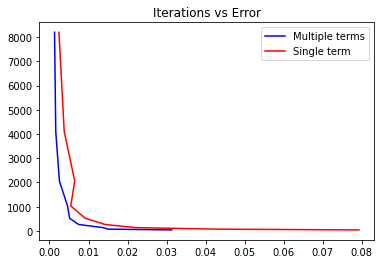

In [7]:
plt.title('Iterations vs Error')
plt.plot(errors, Ns, 'b-', label='Multiple terms', markersize=3)
plt.plot(errors1, Ns, 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

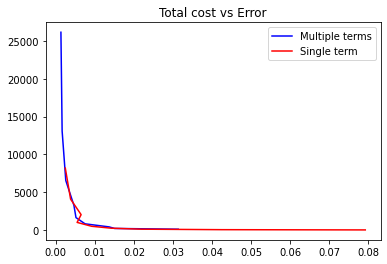

In [8]:
plt.title('Total cost vs Error')
plt.plot(errors, tcosts, 'b-', label='Multiple terms', markersize=3)
plt.plot(errors1, Ns, 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

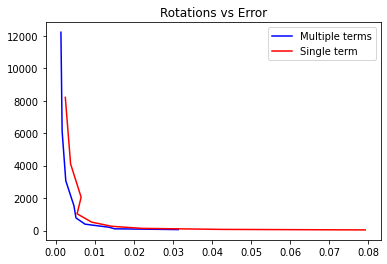

In [9]:
plt.title('Rotations vs Error')
plt.plot(errors, rcosts, 'b-', label='Multiple terms', markersize=3)
plt.plot(errors1, Ns, 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

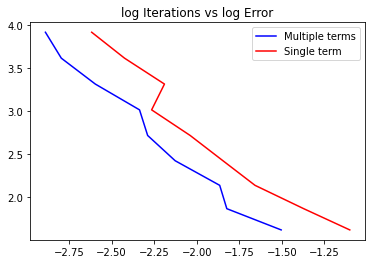

In [10]:
plt.title('log Iterations vs log Error')
plt.plot(np.log10(errors), np.log10(Ns), 'b-', label='Multiple terms', markersize=3)
plt.plot(np.log10(errors1), np.log10(Ns), 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

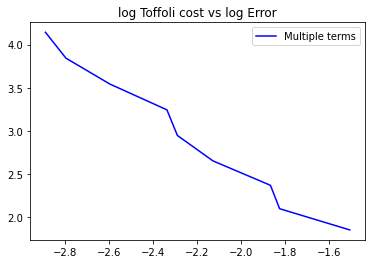

In [11]:
toffcost = tcosts - rcosts

plt.title('log Toffoli cost vs log Error')
plt.plot(np.log10(errors), np.log10(toffcost), 'b-', label='Multiple terms', markersize=3)
plt.legend()
plt.show()

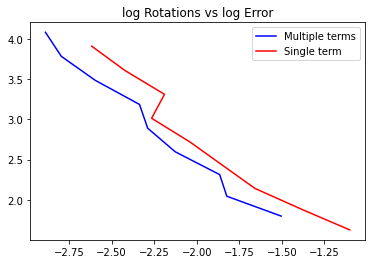

In [12]:
plt.title('log Rotations vs log Error')
plt.plot(np.log10(errors), np.log10(rcosts), 'b-', label='Multiple terms', markersize=3)
plt.plot(np.log10(errors1), np.log10(Ns), 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

In [13]:
print(errors1[-1], errors[-1])

0.0024188845228407673 0.0012941429904111173


In [14]:
# np.savetxt('rcosts', rcosts)
# np.savetxt('tcosts', tcosts)
# np.savetxt('errors', errors)
# np.savetxt('errors1', errors1)
# np.savetxt('Ns', Ns)

In [15]:
# CHs, Chs, CPs = Greedy_Cliques(Hs, hs, Ps)
# tcost, icosts = Simulation_cost(Chs, CPs)
# SHs, Shs = Hs_sum(CHs, Chs)
# Hs_s, hs_s, icosts = Hs_sum_costs(SHs, Shs, icosts)